# Background

Out of curiosity I wanted to visualize the relationship between global economic growth, carbon emissions and energy use.

In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

In [241]:
sns.set_style("whitegrid")

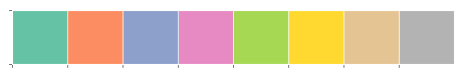

In [142]:
colors = sns.color_palette("Set2")
sns.palplot(colors)

## Carbon emissions

**Reference:**

National CO2 Emissions from Fossil-Fuel Burning, Cement Manufacture, and Gas Flaring: 1751-2014      
                                                     
*doi 10.3334/CDIAC/00001_V2017*
                                                     
March 5, 2017                                       
                                                     
Source:
Tom Boden, Bob Andres                                 
Carbon Dioxide Information Analysis Center 
Oak Ridge National Laboratory              
Oak Ridge, Tennessee 37831-6290 USA        
                                                     
Gregg Marland                              
Research Institute for Environment, Energy and Economics                            
Appalachian State University               
Boone, North Carolina, 28608-2131 USA      

In [14]:
f = "nation.1751_2014.ems"
c = {}
with open(f, 'r') as fhin:
    for line in fhin:
        line = line.rstrip()
        try: 
            y = int(line[0:4])
            emission = int(line.rsplit()[1])
            try:
                c[y]+=emission
            except KeyError:
                c[y] = emission
        except ValueError:
            continue
em = pd.DataFrame(c, index=["C"]).T.sort_index()

Plot carbon emissions per year.

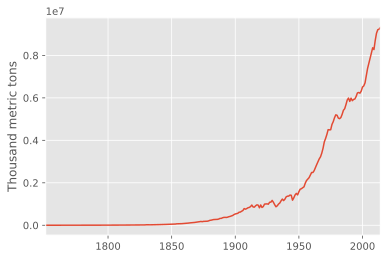

In [158]:
ax = em.plot(legend=None)
ax.set_ylabel("Thousand metric tons");

Calculate increase in emissions from year to year.

## Gross Domestic Product (GDP)

**Reference:**

https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

In [95]:
gdp = pd.read_csv("GDP_per_country.tsv", sep="\t", header=0)
gdp = gdp.loc[(gdp["Series Name"]=="GDP (current US$)")&(gdp["Country Name"]=="World"), list(gdp.columns)[4:]]
gdp = gdp.T
gdp.rename(index=lambda x: int(x[0:4]), inplace=True)
gdp.columns = ["GDP"]
# Divide by 10^12 to get trillions
gdp = gdp.assign(GDP_trill = pd.Series(gdp.GDP/1000000000000, index=gdp.index))

Plot World GDP growth from 1960 to 2018.

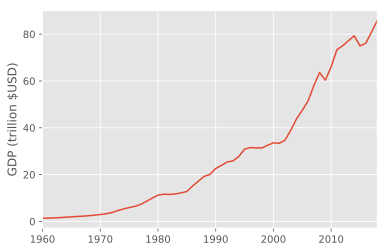

In [96]:
ax = gdp.loc[:,"GDP_trill"].plot()
ax.set_ylabel("GDP (trillion $USD)");

Merge GDP and emissions data.

In [227]:
df = pd.merge(gdp, em, left_index=True, right_index=True, how="inner")

In [228]:
df.head()

,GDP,GDP_trill,C
1960,1.367630e+12,1.367630,2485885
1961,1.422552e+12,1.422552,2484994
1962,1.527270e+12,1.527270,2573168
1963,1.644512e+12,1.644512,2719687
1964,1.802086e+12,1.802086,2857853


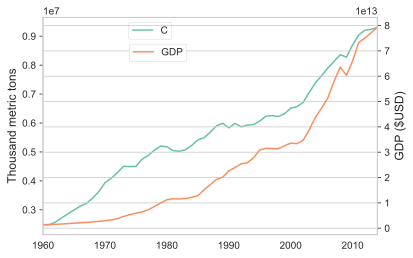

In [230]:
ax1 = df.C.plot(color=colors[0])
ax1.set_ylabel("Thousand metric tons");
ax2 = df.GDP.plot(color=colors[1], secondary_y=True)
ax1.legend(bbox_to_anchor=(0.4,1))
ax2.legend(bbox_to_anchor=(0.445,0.9))
ax2.set_ylabel("GDP ($USD)");

Divide emissions by GDP to get C emissions per $USD.

In [232]:
df = df.assign(C_USD = pd.Series(df.C.div(df.GDP), index=df.index))

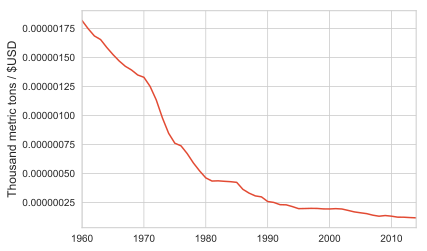

In [233]:
ax = df.C_USD.plot()
ax.set_ylabel("Thousand metric tons / $USD");

This shows the relative decoupling of the economy. More economic activity per unit carbon emitted.

Perform a simple regression of GDP and C.

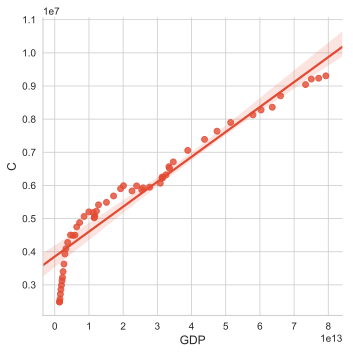

In [234]:
sns.lmplot(data=df.loc[:,["GDP","C"]], x="GDP", y="C", robust=True)

# Energy

**Reference:**

Energy consumption from [BP energy review](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy/downloads.html).

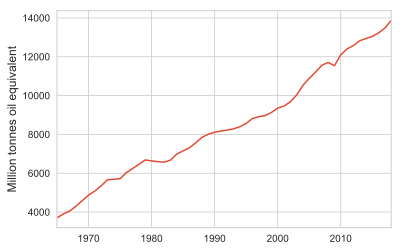

In [235]:
en = pd.read_csv("world_energy.tsv", sep="\t", header=0, index_col=0).T
en.columns = ["Energy"]
en.rename(index = lambda x: int(x), inplace=True)
ax = en.plot(legend=None)
ax.set_ylabel("Million tonnes oil equivalent");

In [236]:
table = pd.merge(df, en, left_index=True, right_index=True)
table.head()

,GDP,GDP_trill,C,C_USD,Energy
1965,1.962035e+12,1.962035,2991511,0.000002,3703.4
1966,2.128407e+12,2.128407,3127495,0.000001,3904.3
1967,2.264999e+12,2.264999,3223830,0.000001,4052.1
1968,2.443378e+12,2.443378,3399752,0.000001,4298.0
1969,2.690561e+12,2.690561,3628346,0.000001,4591.1


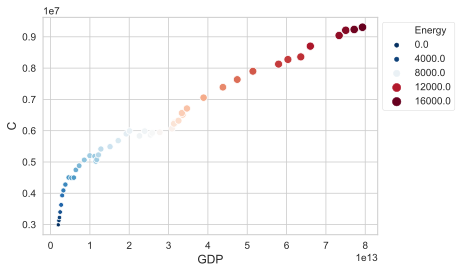

In [238]:
ax = sns.scatterplot(data=table, x="GDP", y="C", hue="Energy", palette="RdBu_r", size="Energy")
ax.legend(bbox_to_anchor=(1,1));

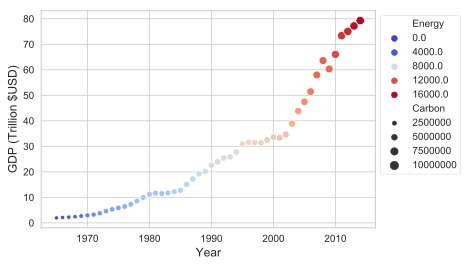

In [239]:
ax = sns.scatterplot(data=table.reset_index().rename(columns = {'C': 'Carbon'}), x="index", y="GDP_trill", size="Carbon", hue="Energy", palette="coolwarm")
[t for t in ax.legend().get_texts()]
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Year");
ax.set_ylabel("GDP (Trillion $USD)");
plt.savefig("BNP_energi_C.png", dpi=300, bbox_inches="tight")